# Regression with a modular simulation model
* The semi empirical rudder is not part of the regression, but needs to be subtracted from the left hand side.
* Now also with propeller model
* And wind system

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from vessel_manoeuvring_models.models.wind_force import WindForceSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")
model_loader_7m = catalog.load(f"7m.models")


[07/24/23 09:44:29] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=982978;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=442619;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/24/23 09:44:40] INFO     Kedro project phd                                                      ]8;id=14416;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=933785;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=715803;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=406991;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=889638;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=76477;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=50452;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=340045;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=134459;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=839661;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=989404;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=990246;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=209952;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=131562;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=909026;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=874015;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=835391;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=146055;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=570317;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=445353;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model_loader.keys()

dict_keys(['vmm_7m_vct.MDL_hull_inverse_dynamics', 'vmm_7m_vct.VCT_MDL_resistance', 'vmm_7m_vct.vct', 'vmm_7m_vct_wind.MDL_hull_inverse_dynamics', 'vmm_7m_vct_wind.VCT_MDL_resistance', 'vmm_7m_vct_wind.vct', 'vmm_martins_simple.MDL_hull_inverse_dynamics', 'vmm_martins_simple.VCT_MDL_resistance', 'vmm_martins_simple.vct', 'vmm_martins_simple_thrust.MDL_inverse_dynamics', 'vmm_simple.VCT_MDL_resistance', 'vmm_simple.vct', 'vmm_simple_wind.VCT_MDL_resistance', 'vmm_simple_wind.vct'])

In [6]:
model= model_loader["vmm_7m_vct.VCT_MDL_resistance"]()

In [7]:
ship_data_7m = catalog.load(f"7m.ship_data")

[07/24/23 09:45:39] INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=598338;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=456071;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [8]:
ship_data['A_XV'] = ship_data_7m['A_XV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['A_YV'] = ship_data_7m['A_YV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['rho_A'] = ship_data_7m['rho_A']
model.ship_parameters.update(ship_data)

In [9]:
#A_XV: 1.120  # Transverse projected area above the waterline including superstructures
#A_YV: 6.037  # Longitudinal projected area above the waterline including superstructures
#rho_A: 1.225 # Mass density of air [kg/m3]

In [10]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
data['twa'] = 0
data['tws'] = 0


In [11]:
result = model.simulate(data)

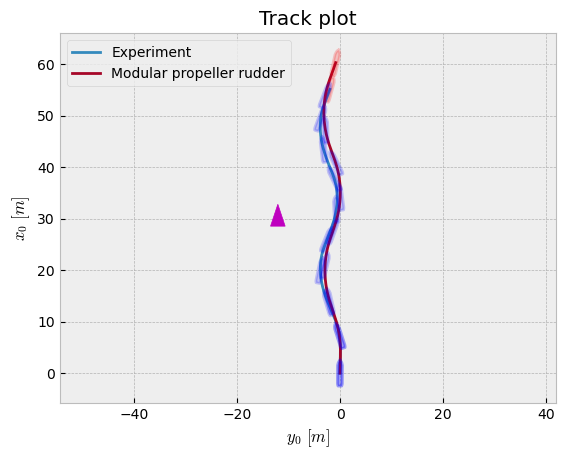

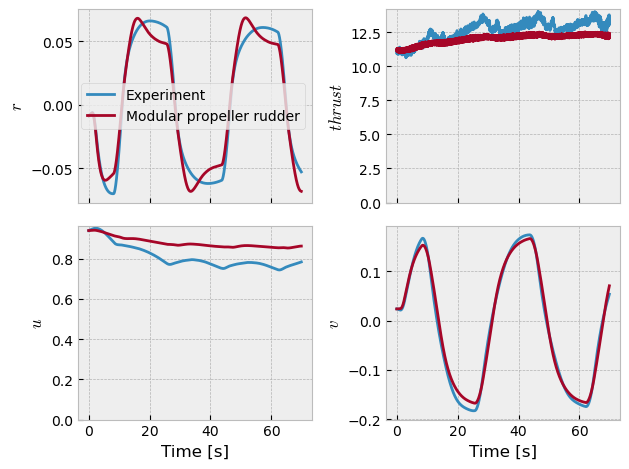

In [12]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [13]:
model.subsystems

{'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7f2892ba5e70>,
 'propellers': <vessel_manoeuvring_models.models.propeller.PropellersSystem at 0x7f2892a60df0>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7f2892f09f30>,
 'wind_force': <vessel_manoeuvring_models.models.wind_force.DummyWindForceSystem at 0x7f2892d7e590>}

In [14]:
wind_force = WindForceSystem(ship=model, create_jacobians=False)

In [15]:
wind_force.lambdas['awa']

<function vessel_manoeuvring_models.models.wind_force.WindForceSystem.__init__.<locals>.awa_signed_angle(U, cog, psi, twa, tws)>

In [16]:
for eq in wind_force.equations.values():
    display(eq)

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa))

Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A)

Eq(N_W, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [17]:
wind_force.equations['aws']

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [18]:
def function_eq(eq):
    return sp.Eq(sp.Function(eq.lhs)(*list(eq.rhs.free_symbols)),eq.rhs)        

In [19]:
function_eq(wind_force.equations['aws'])

Eq(aws(cog, tws, twa, U), sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [20]:
wind_force.equations['awa']

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

In [21]:
from vessel_manoeuvring_models.apparent_wind import *
V

(U*cos(cog))*N.i + (U*sin(cog))*N.j

In [22]:
V_S = u * S.i + v * S.j
V_S

u*S.i + v*S.j

In [29]:
N

N

In [23]:
V_N = express(V_S,N)
V_N

(u*cos(\Psi) - v*sin(\Psi))*N.i + (u*sin(\Psi) + v*cos(\Psi))*N.j

In [24]:
V_N.dot(N.j)

u*sin(\Psi) + v*cos(\Psi)

In [25]:
V_N.dot(N.i)

u*cos(\Psi) - v*sin(\Psi)

In [26]:
sp.simplify(sp.atan(V_N.dot(N.j) / (V_N.dot(N.i))).diff(u))

-v/(u**2 + v**2)

In [27]:
eq_cog = sp.Eq(cog,sp.atan2(V_N.dot(N.j), (V_N.dot(N.i))))
eq_cog

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

In [28]:
sp.simplify(eq_cog.rhs.diff(u))

-v/(u**2 + v**2)

## Coefficients

In [ ]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index
wind_data_HMD.index = np.deg2rad(wind_data_HMD.index)
wind_data_HMD.index = np.mod(wind_data_HMD.index + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = wind_data_HMD.index
wind_data_HMD.index.name = "awa [rad]"
wind_data_HMD.sort_index(inplace=True)
wind_data_HMD.to_csv("../data/01_raw/7m/HMD_PCTC.wind_data.csv", index=True)

In [ ]:
from vessel_manoeuvring_models.models.wind_force import eq_C_x, eq_C_y, eq_C_n, C_x, C_y, C_n

In [ ]:
eq_to_matrix_C_x = DiffEqToMatrix(eq_C_x, label=C_x, base_features=[awa])
eq_to_matrix_C_y = DiffEqToMatrix(eq_C_y, label=C_y, base_features=[awa])
eq_to_matrix_C_n = DiffEqToMatrix(eq_C_n, label=C_n, base_features=[awa])

In [ ]:
eq_C_x

In [ ]:
params_wind = {}
for key,eq_to_matrix in zip(['cx','cy','cn'], [eq_to_matrix_C_x, eq_to_matrix_C_y, eq_to_matrix_C_n]):

    X,y = eq_to_matrix.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD[key], simplify_names=False)
    ols = sm.OLS(y,X, hasconst=False)
    ols_fit = ols.fit()
    params_wind.update(ols_fit.params)
    
    fig,ax=plt.subplots()
    y.plot(ax=ax,style='o', label='data')
    y_pred = ols_fit.predict(X)
    y_pred.plot(ax=ax, label='model')
    ax.set_ylabel(key)
    ax.legend()
    
params_wind = {key:value/2 for key,value in params_wind.items()}  # Note

## Rebuild ship model

In [ ]:
function_eq(wind_force.equations['X_W']).lhs

In [ ]:
X_eq = sp.Eq(model.X_eq.lhs, model.X_eq.rhs + function_eq(wind_force.equations['X_W']).lhs)
Y_eq = sp.Eq(model.Y_eq.lhs, model.Y_eq.rhs + function_eq(wind_force.equations['Y_W']).lhs)
N_eq = sp.Eq(model.N_eq.lhs, model.N_eq.rhs + function_eq(wind_force.equations['N_W']).lhs)

In [ ]:
parameters = model.parameters.copy()
parameters.update(params_wind)
ship_parameters = model.ship_parameters.copy()
ship_parameters.update(ship_data)

In [ ]:
model_wind = model.copy()
model_wind.__init__(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                    parameters=parameters, 
                    ship_parameters=ship_parameters, 
                    control_keys=['delta','rev','twa','tws'], # NOTE! 
                    do_create_jacobian=False)
model_wind.subsystems

In [ ]:
assert model_wind.subsystems['propellers'].ship == model_wind
assert model_wind.subsystems['propellers'].ship != model


In [ ]:
model_wind.subsystems['wind_force'] = wind_force.copy_and_refer_other_ship(ship=model_wind)

## Save model

In [ ]:
model_loader["MDL_modular_propeller_rudder_wind"] = model_wind
catalog.save(f"{ship}.models",model_loader)

In [ ]:
result_wind = model_wind.simulate(data)

In [ ]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
              'Modular propeller rudder wind':result_wind,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [ ]:
result_wind.head()

In [ ]:
result_wind.plot(y='awa')

In [ ]:
fig,axes=plt.subplots(nrows=3)
fig.set_size_inches(9,9)
for ax,key in zip(axes,['X','Y','N']):
    mask = result_wind.columns.str.contains(key)
    columns = list(result_wind.columns[mask])
    columns.remove(f'{key}_D')
    result_wind.plot(y=columns,ax=ax)

In [ ]:
ship_data

In [ ]:
result_wind['C_x'] = result_wind['X_W'] / (result_wind['aws']**2*ship_data['A_XV']*ship_data['rho_A'])
result_wind['C_y'] = result_wind['Y_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['rho_A'])
result_wind['C_n'] = result_wind['N_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['L']*ship_data['rho_A'])

In [ ]:
result_wind.plot(x='awa', y='C_x', style='.')

In [ ]:
result_wind.plot(x='awa', y='C_y', style='.')

In [ ]:
result_wind.plot(x='awa', y='C_n', style='.')

## Also create a 7m model

In [ ]:
ship_data_7m

In [ ]:
ship_parameters_7m = ship_parameters.copy()
ship_parameters_7m.update(ship_data_7m)
scale_7 = ship_data_7m['scale_factor']
scale_5 = ship_data['scale_factor']
scaling = scale_5/scale_7 
ship_parameters_7m['x_p']*=scaling
ship_parameters_7m['x_R']*=scaling
ship_parameters_7m['A_R']*=(scale_5**2)/(scale_7**2)
ship_parameters_7m['b_R']*=scaling
ship_parameters_7m['r_0']=ship_parameters_7m['D']/2
ship_parameters_7m['x']*=scaling


In [ ]:
ship_parameters_7m

In [ ]:
df_ship_parameters = pd.concat((
    pd.Series(ship_parameters_7m, name='7m'),
    pd.Series(ship_parameters, name='5m')),axis=1).transpose()
compare = df_ship_parameters.loc['7m']/df_ship_parameters.loc['5m']
compare.plot.bar()

In [ ]:
mask = compare == 1
compare.loc[mask].index

In [ ]:
model_wind_7m = model_wind.copy()
model_wind_7m.ship_parameters=ship_parameters_7m

## Save model

In [ ]:
#model_loader_7m["MDL_modular_propeller_rudder_wind"] = model_wind_7m
#catalog.save(f"7m.models",model_loader_7m)

In [ ]:
result_wind_7m = model_wind_7m.simulate(data)

In [ ]:
dataframes = {
              'Modular propeller rudder wind':result_wind,
              'Modular propeller rudder wind 7m':result_wind_7m,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [ ]:
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters
initial_parameters(ship_data=ship_data)

In [ ]:
ship_data_7m_ = ship_data.copy()
scale_7 = ship_data_7m['scale_factor']
scale_5 = ship_data['scale_factor']
scaling = scale_5/scale_7 


ship_data_7m_['T']*=scaling
ship_data_7m_['L']*=scaling
#ship_data_7m_['CB': 0.45034232324249973,
ship_data_7m_['B']*=scaling
#ship_data_7m_['rho': 1000,
ship_data_7m_['x_G']*=scaling
ship_data_7m_['m']*=scaling**3
ship_data_7m_['I_z']*=scaling**5
ship_data_7m_['volume']*=scaling**3

initial_parameters(ship_data=ship_data_7m_)

In [ ]:
ship_data['B']/ship_data['T']

In [ ]:
ship_data_7m['B']/ship_data_7m['T']